In [2]:
# !pip install spacy gensim sentence_transformers

import spacy
spacy.cli.download("en_core_web_sm")

e:\Eric\Simplon\NLP_aout2022\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score

from gensim.models.word2vec import Word2Vec
import gensim.downloader
from sentence_transformers import SentenceTransformer

In [4]:
data_url = 'https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv'
spooky_df = pd.read_csv(data_url)
spooky_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
def clean_docs(texts, remove_stopwords=False, n_process = 4):
    
    docs = nlp.pipe(texts, 
                    n_process=n_process,
                    disable=['parser', 'ner',
                             'lemmatizer', 'textcat'])
    stopwords = nlp.Defaults.stop_words

    docs_cleaned = []
    for doc in docs:
        tokens = [tok.text.lower().strip() for tok in doc if not tok.is_punct]
        if remove_stopwords:
            tokens = [tok for tok in tokens if tok not in stopwords]
        doc_clean = ' '.join(tokens)
        docs_cleaned.append(doc_clean)
        
    return docs_cleaned

In [7]:
spooky_df['text_clean'] = clean_docs(spooky_df['text'])
spooky_df.head()

,id,text,author,text_clean
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...


In [8]:
le = LabelEncoder()
spooky_df['author_encoded'] = le.fit_transform(spooky_df['author'])
le.classes_

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(spooky_df['text_clean'].values, 
                                                    spooky_df['author_encoded'].values, 
                                                    test_size=0.2, 
                                                    random_state=33,
                                                    stratify = spooky_df['author_encoded'].values)

In [10]:
print(100*y_train.tolist().count(0)/(len(y_train)))
print(100*y_test.tolist().count(0)/(len(y_test)))

40.349869118304284
40.34729315628192


In [20]:
X_train[0]

'for the first time during many hours or perhaps days i thought'

In [19]:
print(y_train[0], le.inverse_transform([y_train[0]])[0])

0 EAP


<AxesSubplot:>

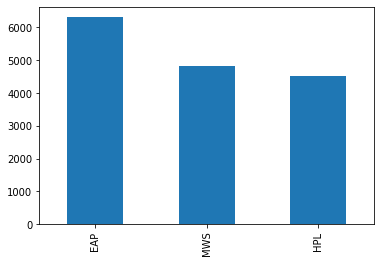

In [21]:
fig = pd.Series(le.inverse_transform(y_train)).value_counts().plot(kind='bar')
fig

In [22]:
# Suppression des stop words
X_train_no_sw = clean_docs(X_train, remove_stopwords=True)
X_train_no_sw = np.array(X_train_no_sw)

In [36]:
def plot_top_words(initials, ax, n_words=20):
    # Calcul des mots les plus fréquemment utilisés par l'auteur
    texts = X_train_no_sw[le.inverse_transform(y_train) == initials]
    all_tokens = ' '.join(texts).split()
    counts = Counter(all_tokens)
    top_words = [word[0] for word in counts.most_common(n_words)]
    top_words_counts = [word[1] for word in counts.most_common(n_words)]
    
    # Représentation sous forme de barplot
    ax = sns.barplot(ax = ax, x=top_words, y=top_words_counts)
    ax.set_title(f'Most Common Words used by {initials_to_author[initials]}')

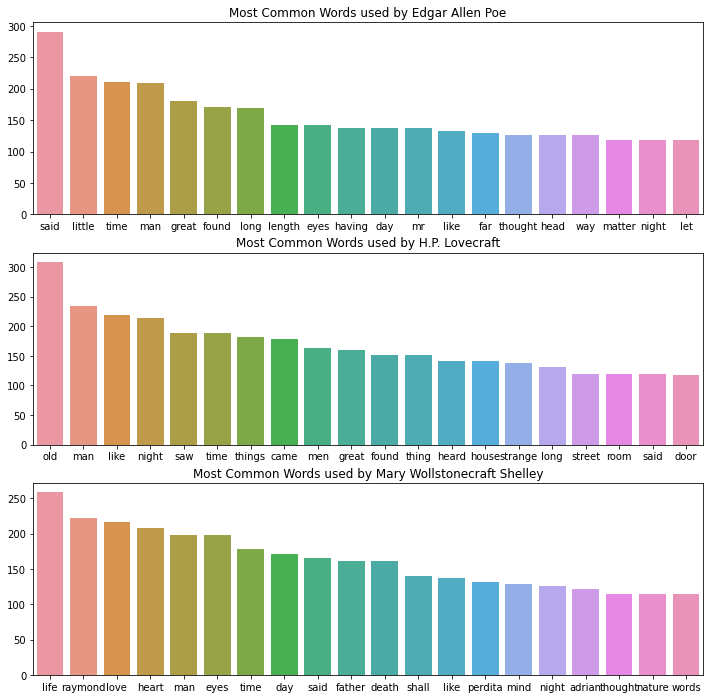

In [37]:
initials_to_author = {
    'EAP': 'Edgar Allen Poe',
    'HPL': 'H.P. Lovecraft',
    'MWS': 'Mary Wollstonecraft Shelley'
}

fig, axs = plt.subplots(3, 1, figsize = (12,12))

plot_top_words('EAP', ax = axs[0])
plot_top_words('HPL', ax = axs[1])
plot_top_words('MWS', ax = axs[2])

In [38]:
# Prédiction sur le set d'entrainement
clf = LinearSVC(max_iter=10000, C=0.1)

In [41]:
def fit_vectorizers(vectorizer):
    pipeline = Pipeline(
    [
        ("vect", vectorizer()),
        ("scaling", StandardScaler(with_mean=False)),
        ("clf", clf),
    ]
    )

    parameters = {
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        "vect__stop_words": ("english", None)
    }

    grid_search = GridSearchCV(pipeline, parameters, scoring='f1_micro',
                               cv=4, n_jobs=4, verbose=1)
    grid_search.fit(X_train, y_train)

    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    print(f"CV scores {grid_search.cv_results_['mean_test_score']}")
    print(f"Mean F1 {np.mean(grid_search.cv_results_['mean_test_score'])}")
    
    return grid_search

In [40]:
cv_bow = fit_vectorizers(CountVectorizer)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
	vect__ngram_range: (1, 2)
	vect__stop_words: None
CV scores [0.65613231 0.68467074 0.59318236 0.78152334]
Mean F1 0.6788771863997067


In [42]:
print(cv_bow)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('scaling',
                                        StandardScaler(with_mean=False)),
                                       ('clf',
                                        LinearSVC(C=0.1, max_iter=10000))]),
             n_jobs=4,
             param_grid={'vect__ngram_range': ((1, 1), (1, 2)),
                         'vect__stop_words': ('english', None)},
             scoring='f1_micro', verbose=1)


In [43]:
cv_tfidf = fit_vectorizers(TfidfVectorizer)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
	vect__ngram_range: (1, 2)
	vect__stop_words: None
CV scores [0.68486264 0.72438203 0.75381483 0.80852971]
Mean F1 0.7428973032990371


In [44]:
X_train_tokens = [text.split() for text in X_train]
w2v_model = Word2Vec(X_train_tokens, vector_size=200, window=5, 
                     min_count=1, workers=4)

In [64]:
w2v_model.wv.most_similar('mother')

[('brother', 0.9885303378105164),
 ('own', 0.9870707392692566),
 ('daughter', 0.9846564531326294),
 ('earnest', 0.9841771125793457),
 ('countenance', 0.9829790592193604),
 ('sister', 0.9829391241073608),
 ('gesture', 0.9824192523956299),
 ('soul', 0.9822794795036316),
 ('wife', 0.9819296002388),
 ('services', 0.9792946577072144)]

In [65]:
w2v_model.wv.most_similar('night')

[('day', 0.9761525392532349),
 ('same', 0.9752716422080994),
 ('morning', 0.9739955067634583),
 ('first', 0.972938060760498),
 ('house', 0.97020423412323),
 ('noon', 0.9699417352676392),
 ('autumn', 0.9676735997200012),
 ('sight', 0.9669336676597595),
 ('painting', 0.965823769569397),
 ('meantime', 0.9651690125465393)]

In [54]:
def get_mean_vector(w2v_vectors, words):
    words = [word for word in words if word in w2v_vectors]
    if words:
        avg_vector = np.mean(w2v_vectors[words], axis=0)
    else:
        avg_vector = np.zeros_like(w2v_vectors['hi'])
    return avg_vector

def fit_w2v_avg(w2v_vectors):
    X_train_vectors = np.array([get_mean_vector(w2v_vectors, words)
                                for words in X_train_tokens])
    
    scores = cross_val_score(clf, X_train_vectors, y_train, 
                         cv=4, scoring='f1_micro', n_jobs=4)

    print(f"CV scores {scores}")
    print(f"Mean F1 {np.mean(scores)}")
    return scores

In [55]:
cv_w2vec = fit_w2v_avg(w2v_model.wv)

CV scores [0.56230848 0.55311542 0.55081716 0.56628352]
Mean F1 0.5581311468031732


In [56]:
glove_model = gensim.downloader.load('glove-wiki-gigaword-200')

[==================================================] 100.0% 252.1/252.1MB downloaded


In [57]:
glove_model['king']

array([-0.49346  , -0.14768  ,  0.32166  ,  0.056899 ,  0.052572 ,
        0.20192  , -0.13506  , -0.030793 ,  0.15614  , -0.23004  ,
       -0.66376  , -0.27316  ,  0.10391  ,  0.57334  , -0.032355 ,
       -0.32766  , -0.2716   ,  0.32919  ,  0.41305  , -0.18085  ,
        1.5167   ,  2.1649   , -0.10278  ,  0.098019 , -0.018946 ,
        0.027292 , -0.7948   ,  0.36631  , -0.33151  ,  0.2884   ,
        0.10436  , -0.19166  ,  0.27326  , -0.17519  , -0.14986  ,
       -0.072333 , -0.54371  , -0.29728  ,  0.081491 , -0.42673  ,
       -0.36406  , -0.52035  ,  0.18455  ,  0.44121  , -0.32196  ,
        0.39172  ,  0.11952  ,  0.36979  ,  0.29229  , -0.42954  ,
        0.46653  , -0.067243 ,  0.31216  , -0.17216  ,  0.48874  ,
        0.2803   , -0.17577  , -0.35101  ,  0.020792 ,  0.15974  ,
        0.21927  , -0.32499  ,  0.086022 ,  0.38927  , -0.65638  ,
       -0.67401  , -0.41896  ,  1.2709   ,  0.20857  ,  0.28315  ,
        0.58238  , -0.14944  ,  0.3989   ,  0.52681  ,  0.3571

In [61]:
glove_model.most_similar('mother')

[('daughter', 0.8648022413253784),
 ('wife', 0.8568021655082703),
 ('grandmother', 0.8373793363571167),
 ('husband', 0.8055646419525146),
 ('sister', 0.8029242157936096),
 ('father', 0.7936768531799316),
 ('her', 0.783749520778656),
 ('daughters', 0.7589756846427917),
 ('woman', 0.7579867243766785),
 ('she', 0.7452898025512695)]

In [62]:
glove_model.most_similar(positive = ['king', 'woman'], negative = ['man'])


[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]

In [66]:
# glove_model.most_similar(positive = ['king', 'woman'], negative = ['man'])
glove_model.most_similar('night')

[('evening', 0.8015445470809937),
 ('saturday', 0.766251802444458),
 ('sunday', 0.766112744808197),
 ('morning', 0.7611642479896545),
 ('afternoon', 0.745530366897583),
 ('weekend', 0.7276031374931335),
 ('day', 0.7088316082954407),
 ('friday', 0.6997552514076233),
 ('nights', 0.6951433420181274),
 ('hours', 0.69302898645401)]

In [67]:
cv_w2vec_transfert = fit_w2v_avg(glove_model)

CV scores [0.67696629 0.67262513 0.66905005 0.68633461]
Mean F1 0.6762440203403008


In [68]:
perfs = pd.DataFrame(
    [np.mean(cv_bow.cv_results_['mean_test_score']),
     np.mean(cv_tfidf.cv_results_['mean_test_score']),
    np.mean(cv_w2vec),
    np.mean(cv_w2vec_transfert)],
    index = ['Bag-of-Words','TF-IDF', 'Word2Vec non pré-entraîné', 'Word2Vec pré-entraîné'],
    columns = ["Mean F1 score"]
).sort_values("Mean F1 score",ascending = False)
perfs


,Mean F1 score
TF-IDF,0.742897
Bag-of-Words,0.678877
Word2Vec pré-entraîné,0.676244
Word2Vec non pré-entraîné,0.558131


In [69]:
model = SentenceTransformer('all-mpnet-base-v2')


Downloading: 100%|██████████| 1.18k/1.18k [00:00<00:00, 582kB/s]
Downloading: 100%|██████████| 190/190 [00:00<00:00, 95.0kB/s]
Downloading: 100%|██████████| 10.6k/10.6k [00:00<00:00, 3.53MB/s]
Downloading: 100%|██████████| 116/116 [00:00<00:00, 11.6kB/s]
Downloading: 100%|██████████| 39.3k/39.3k [00:00<00:00, 378kB/s] 
Downloading: 100%|██████████| 438M/438M [02:02<00:00, 3.56MB/s] 
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 26.5kB/s]
Downloading: 100%|██████████| 239/239 [00:00<00:00, 79.7kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 1.11MB/s]
Downloading: 100%|██████████| 363/363 [00:00<00:00, 181kB/s]
Downloading: 100%|██████████| 13.1k/13.1k [00:00<00:00, 170kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 735kB/s]  
Downloading: 100%|██████████| 349/349 [00:00<00:00, 87.2kB/s]


In [70]:
X_train_vectors = model.encode(X_train)


In [71]:
scores = cross_val_score(clf, X_train_vectors, y_train, 
                         cv=4, scoring='f1_micro', n_jobs=4)

print(f"CV scores {scores}")
print(f"Mean F1 {np.mean(scores)}")


CV scores [0.75       0.7308478  0.74361593 0.75376756]
Mean F1 0.7445578247931987


In [72]:
perfs = pd.concat(
  [perfs,
  pd.DataFrame(
    [np.mean(scores)],
    index = ['Contextual Embedding'],
    columns = ["Mean F1 score"])]
).sort_values("Mean F1 score",ascending = False)
perfs


,Mean F1 score
Contextual Embedding,0.744558
TF-IDF,0.742897
Bag-of-Words,0.678877
Word2Vec pré-entraîné,0.676244
Word2Vec non pré-entraîné,0.558131
